In [18]:
import numpy as np
np.set_printoptions(precision=6)
import copy
#utilizaremos o pandas para lidar com o arquivo csv do dataset
import pandas as pd
#utilizaremos funções utilitárias do scikit learn para preparar os dados
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit
#utilizaremos o matplotlib para exibir gráficos
import matplotlib.pyplot as plt

#utilizaremos o pytorch como biblioteca para a rede neural
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
#importamos o dataset e exibimos suas 5 primeiras linhas com a função "head"
skyserver_df = pd.read_csv('input/Skyserver_SQL2_27_2018 6_51_39 PM.csv')
skyserver_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


Text(0.5, 1.0, 'Correlation Matrix')

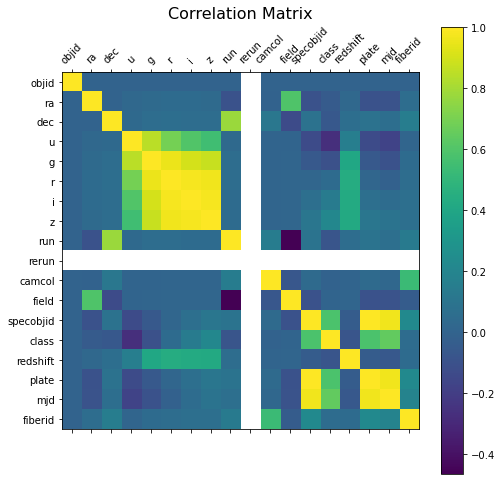

In [3]:
#criamos uma copia do dataset para exibir a matriz de correlação
correlation_skyserver_df = copy.deepcopy(skyserver_df)

#usamos LabelEncoder para transformar as classes categóricas em numéricas
le = LabelEncoder()
#o LabelEncoder é então aplicado sobre a cópia do dataset
correlation_skyserver_df['class'] = le.fit_transform(skyserver_df['class'])
#criamos a matriz de correlação
correlation_matrix = correlation_skyserver_df.corr()

#f define a figura e seu tamanho
f = plt.figure(figsize=(8, 8))
#matshow define os dados do grafico a ser exibido
plt.matshow(correlation_matrix, fignum=f.number)
#legenda do eixo x
plt.xticks(range(correlation_skyserver_df.select_dtypes(['number']).shape[1]), correlation_skyserver_df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
#legenda do eixo y
plt.yticks(range(correlation_skyserver_df.select_dtypes(['number']).shape[1]), correlation_skyserver_df.select_dtypes(['number']).columns, fontsize=10)
#colorbar instancia uma barra de legenda para melhor visualização
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
#colocamos um título no gráfico
plt.title('Matriz de Correlação', fontsize=16)

In [4]:
#exibimos os valores de correlação das variáveis do dataset com a classe
with pd.option_context('display.float_format', '{:0.6f}'.format):
    print(correlation_matrix['class'])

objid       -0.000000
ra          -0.043219
dec         -0.058918
u           -0.269044
g           -0.099212
r            0.049628
i            0.146791
z            0.215758
run         -0.078162
rerun             nan
camcol      -0.006186
field        0.007713
specobjid    0.585493
class        1.000000
redshift    -0.075510
plate        0.585495
mjd          0.648768
fiberid      0.053593
Name: class, dtype: float64


In [5]:
#eliminamos as colunas com dados irrelevantes à classificação
skyserver_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid', 'mjd'], axis=1, inplace=True)

**Testar com "specobjid" e "mjd"**

In [8]:
#usamos LabelEncoder para transformar as classes categóricas em numéricas
le = LabelEncoder()
#o LabelEncoder é aplicado sobre o dataset
y_numerical_classes = le.fit_transform(skyserver_df['class'])
#visto que as classes estão na variável y_encoded, podemos eliminar a coluna "class" do dataset
skyserver_df.drop(['class'], axis=1, inplace=True)

y_numerical_classes = y_numerical_classes.reshape(-1, 1)

In [10]:
#visto que será utilizada a função softmax, transformamos as classes em vetores one-hot
enc = OneHotEncoder()
enc.fit(y_numerical_classes)

#aplicamos o OneHotEncoder ao vetor de categorias na forma numérica criado anteriormente
y_encoded = enc.transform(y_numerical_classes)
y_encoded = y_encoded.toarray().tolist()

In [13]:
#normalizamos os parâmetros do dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
skyserver_normalized = scaler.fit_transform(skyserver_df).tolist()

In [19]:
#a função stitch une em uma mesma lista os parametros de treino (x) e a categoria (y)
def stitch(inputs, target):
    series_inputs = pd.Series(inputs)
    series_target = pd.Series(target)
    df = pd.DataFrame({'inputs': series_inputs, 'target': series_target})
    return df.values.tolist()

def unstitch(data):
    df = pd.DataFrame(data)
    return df[0].values.tolist(), df[1].values.tolist()

In [20]:
#unimos os parametros de treino (x) com as categorias (y) em uma única lista com a função stitch
data = stitch(skyserver_normalized, y_encoded)

10000 10000


In [24]:
#separamos o dataset original nos conjuntos de treino, validação e teste
#o conjunto de treino ficou com 60% dos exemplos, enquanto o de validação ficou com 20%,
#e o de testes também com 20%
train, test = train_test_split(data, test_size=0.2, shuffle=True)
train, val = train_test_split(train, test_size=0.25, shuffle=True)

10000
6000 2000 2000


In [ ]:
class Net(nn.Module):
    def __init__(self, dropout=False, weightDecay=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(11, 11) # 2 Input noses, 50 in middle layers
        self.do1 = nn.Dropout(p=0.2)
        self.rl1 = nn.Sigmoid()
        self.fc2 = nn.Linear(11, 3)
        self.do2 = nn.Dropout(p=0.2)
        self.smout = nn.Softmax(dim=1)      
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0)
        self.dropout=dropout
        
        self.cuda()
        
        self.trainOverTimeAccuracy = []
        self.trainOverTimeLoss = []
        self.testOverTimeAccuracy = []
        self.testOverTimeLoss = []
    
    def forward(self, x):
        x = self.fc1(x)
        if self.dropout:
            x = self.do1(x)
        x = self.rl1(x)
        x = self.fc2(x)
        if self.dropout:
            x = self.do1(x)
        x = self.smout(x)
        return x
    
    def log(self, epoch, train, test):
        if epoch % REPORT_RATE == 0:
            self.trainOverTimeAccuracy.append(self.accuracy(train))
            #self.trainOverTimeLoss.append(self.loss(train))
            self.testOverTimeAccuracy.append(self.accuracy(test))
            #self.testOverTimeLoss.append(self.loss(test))
            
    def epochTrain(self, inputs, labels):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        self.loss = self.criterion(outputs, torch.max(labels, 1)[1])
        self.loss.backward()    
        self.optimizer.step()

        
    def train(self, numEpochs, train_set, train, test):
        inputs, labels = unstitch(train_set)
        
        inputs = Variable(torch.FloatTensor(inputs).cuda())
        labels = Variable(torch.FloatTensor(labels).cuda())

        for epoch in range(numEpochs):
            self.epochTrain(inputs, labels)
            self.log(epoch, train, test)
                
    def activetrain(self, activeUpdateRate, batchSize, numEpochs, train, test):
        trainings = int(numEpochs/activeUpdateRate)
        currentEpoch = 0

        for i in range(trainings):
            activecriterion = nn.CrossEntropyLoss(reduction='none')
            
            inputs, labels = unstitch(train)
            
            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            outputs = self(inputs)

            loss = activecriterion(outputs, torch.max(labels, 1)[1]).detach().cpu().numpy()
            sortIndexs = np.argsort(loss)[::-1]
            dynamicTrainSet = np.array(np.copy(train))[sortIndexs]
            dynamicTrainSet = dynamicTrainSet[0:batchSize]

            inputs, labels = unstitch(dynamicTrainSet)
        
            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            for epoch in range(activeUpdateRate):
                currentEpoch += 1
                self.epochTrain(inputs, labels)
                self.log(currentEpoch, train, test)
            
    def randomtrain(self, batchSize, numEpochs, train, test):
        shuffledTrainSet = np.array(np.copy(train))
        for epoch in range(numEpochs):
            np.random.shuffle(shuffledTrainSet)

            inputs, labels = unstitch(shuffledTrainSet[0:batchSize])

            inputs = Variable(torch.FloatTensor(inputs).cuda())
            labels = Variable(torch.FloatTensor(labels).cuda())
            
            self.epochTrain(inputs, labels)
            self.log(epoch, train, test)

            
    def loss(self, test_set):
        inputs, labels = unstitch(test_set)
        inputs = Variable(torch.FloatTensor(inputs).cuda())
        labels = Variable(torch.FloatTensor(labels).cuda())
        result = self(inputs)
        loss = self.criterion(result, torch.max(labels, 1)[1])

        return loss.item()

    def accuracy(self, test_set):
        inputs, labels = unstitch(test_set)
        result = self(Variable(torch.FloatTensor(inputs)).cuda())
        inputs_max = np.argmax(result.detach().cpu().numpy(), axis=1)
        labels_max = np.argmax(np.array(labels), axis=1)
        correct = np.sum(inputs_max == labels_max)

        return correct/len(test_set)

In [ ]:
SAMPLES = 30
NUM_EPOCHS = 2000
BATCH_SIZE = 200
ACTIVE_UPDATE_RATE = 1
REPORT_RATE = 10

%%time
regularisationBatchNets = []
regularisationMiniBatchNets = []
regularisationActiveNets = []

regularisationSchemes = [[False, 0, 'no regularisation'], [True, 0, 'dropout'], [False, 0.01, 'weight decay'], [False, 0.01, 'dropout & weight decay']]

for scheme in regularisationSchemes:
    print(scheme[2])
    batchNets = []
    miniBatchNets = []
    activeNets = []
    for i in range(SAMPLES):
        batchNet = Net(scheme[0], scheme[1])
        batchNet.train(NUM_EPOCHS, train, train, test)
        batchNets.append(batchNet)

        miniBatchNet = Net(scheme[0], scheme[1])
        miniBatchNet.randomtrain(BATCH_SIZE, NUM_EPOCHS, train, test)
        miniBatchNets.append(miniBatchNet)

        activeNet = Net(scheme[0], scheme[1])
        activeNet.activetrain(ACTIVE_UPDATE_RATE, BATCH_SIZE, NUM_EPOCHS, train, test)
        activeNets.append(activeNet)
        
    regularisationBatchNets.append([batchNets, scheme[2]])
    regularisationMiniBatchNets.append([miniBatchNets, scheme[2]])
    regularisationActiveNets.append([activeNets, scheme[2]])

In [ ]:
def buildDataFrame():
    meanTrainAccList = []
    meanTestAccList = []
    meanValAccList = []
    descriptionList = []
    
    padding = ['', '', '', '', '', '', '']
        
    typeList = []
    typeList.extend(['batch'])
    typeList.extend(padding)
    typeList.extend(['random mini batch'])
    typeList.extend(padding)
    typeList.extend(['selective learning'])
    typeList.extend(padding)
    for scheme in regularisationBatchNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    for scheme in regularisationMiniBatchNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    for scheme in regularisationActiveNets:
        trainAccuracys = np.array(list(map(lambda x: x.accuracy(train), scheme[0])))
        meanTrainAccList.append(1.0 - np.mean(trainAccuracys))
        meanTrainAccList.append(np.std(trainAccuracys))
        
        testAccuracys = np.array(list(map(lambda x: x.accuracy(test), scheme[0])))
        meanTestAccList.append(1.0 - np.mean(testAccuracys))
        meanTestAccList.append(np.std(testAccuracys))
        
        valAccuracys = np.array(list(map(lambda x: x.accuracy(val), scheme[0])))
        meanValAccList.append(np.mean(testAccuracys / trainAccuracys))
        meanValAccList.append(np.std(testAccuracys / trainAccuracys))
        
        
        descriptionList.append(scheme[1])
        descriptionList.append('')
        
    df = pd.DataFrame({'training': typeList, 'regularisation': descriptionList, '$trainError$': meanTrainAccList, '$testError$': meanTestAccList, '$genFactor$': meanValAccList})
    
    return df

table = buildDataFrame()
table_result = table[['training', 'regularisation', '$trainError$', '$testError$', '$genFactor$']]
table_result

In [ ]:
#print(table_result.to_latex(index=False, bold_rows=True, na_rep=''))
with open('./resulttable.txt', 'w') as f:
    print(table_result.to_latex(index=False, bold_rows=True, na_rep=''), file=f)

In [ ]:
# SMALL_SIZE = 10
# MEDIUM_SIZE = 12

# plt.rc('font', size=SMALL_SIZE)
# plt.rc('axes', titlesize=MEDIUM_SIZE)
# plt.rc('axes', labelsize=MEDIUM_SIZE)
# plt.rcParams['figure.dpi']=150

generations = np.arange(0, NUM_EPOCHS, REPORT_RATE)

plotColors = [
    'b--',
    'r--',
    'g--',
    'k--',
    'g^',
    'k'
]


graphs = [[regularisationBatchNets, 'batch'], [regularisationMiniBatchNets, 'miniBatch'], [regularisationActiveNets, 'active']]
for graph in graphs:
    fig = plt.figure()
    plt.grid(1)
    plt.xlim([0, NUM_EPOCHS])
    plt.ion()
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plots = []
    descriptions = []
    for x, result in enumerate(graph[0]):
        overTimeAccuracy = np.array(list(map(lambda x: x.trainOverTimeAccuracy, result[0])))
        meanOverTimeAccuracy = 1 - np.mean(overTimeAccuracy, axis=0)
        plots.append(plt.plot(generations, meanOverTimeAccuracy, plotColors[x%len(plotColors)] , linewidth=1, markersize=1)[0])
        descriptions.append(result[1])

    plt.legend(plots, descriptions)
    fig.savefig('./' + graph[1] + 'Traning.png')
    plt.show(5)

    plt.close()

In [ ]:
fig = plt.figure()
plt.grid(1)
plt.xlim([0, NUM_EPOCHS])
plt.ion()
plt.xlabel('Generations')
plt.ylabel('Fitness')
plots = []
descriptions = []

things = [[regularisationBatchNets, 'batch'], [regularisationMiniBatchNets, 'miniBatch'], [regularisationActiveNets, 'active']]
for x, graph in enumerate(things):
    
    overTimeAccuracy = np.array(list(map(lambda x: x.trainOverTimeAccuracy, graph[0][0][0])))
    meanOverTimeAccuracy = 1 - np.mean(overTimeAccuracy, axis=0)
    plots.append(plt.plot(generations, meanOverTimeAccuracy, plotColors[x%len(plotColors)] , linewidth=1, markersize=3)[0])
    descriptions.append(graph[1])

plt.legend(plots, descriptions)
fig.savefig('./none.png')
plt.show(5)

plt.close()